In [ ]:
!pip install openai PyMuPDF

In [ ]:
from openai import OpenAI
import openai
import fitz  # PyMuPDF
import re
from io import BytesIO
from PIL import Image
from google.colab import drive
from IPython.display import display
import base64
import requests
import json

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
api_key='secret'

In [ ]:
# Mathpix API 설정
API_URL_TEXT = "secret"
API_URL_PDF = "secret"
APP_ID = "secret"
API_KEY = "secret"

# 옵션 설정
options = {
    "conversion_formats": {"tex.zip": True},
    "rm_spaces": True
}

def image_to_base64(ocr_image_path):
    with open(ocr_image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode()

# PDF 파일을 처리하는 요청
def extract_pdf_content(pdf_path):
    content = ""
    images = []

    # PDF 열기
    with fitz.open(pdf_path) as pdf:
        # 각 페이지를 순회하며 텍스트와 이미지 추출
        for page_num in range(len(pdf)):
            page = pdf[page_num]
            content += page.get_text()

            '''
            # 페이지에 포함된 이미지 정보 추출
            for img_index, img in enumerate(page.get_images(full=True)):
                xref = img[0]
                base_image = pdf.extract_image(xref)
                image_bytes = base_image["image"]
                images.append({
                    "page": page_num + 1,
                    "img_index": img_index + 1,
                    "image_bytes": image_bytes,
                    "image_ext": base_image["ext"]
                })
              '''
    return content

def extract_math_from_image(ocr_image_path):
    headers = {
        "app_id": APP_ID,
        "app_key": API_KEY,
        "Content-type": "application/json",
    }

    data = {
        "src": f"data:image/jpeg;base64,{image_to_base64(ocr_image_path)}",
        "formats": ["text", "latex_simplified"],
        "ocr": ["math", "text"],
    }

    response = requests.post(API_URL_TEXT, headers=headers, json=data)

    if response.status_code == 200:
        result = response.json()
        return result.get("text", "")
        # print("LaTeX Format:", result.get("latex_simplified", ""))
    else:
        print(f"Error: {response.status_code}")
        print(response.text)

def find_solution_for_question(latex_content, question_number):
    # 문제 번호와 정답을 추출하는 패턴 생성
    # LaTeX에서 문제 번호로 시작하는 부분을 찾고, 다음 문제 번호까지의 내용을 추출
    solution_pattern = re.compile(rf"{question_number}\.\s*정답.*?(?=\d+\.\s*정답|\Z)", re.DOTALL)

    # 해당 문제 번호에 맞는 해설을 검색
    match = solution_pattern.search(latex_content)

    if match:
        return match.group().strip()  # 찾은 해설을 반환
    else:
        return "해당 문제에 대한 해설을 찾을 수 없습니다."

In [ ]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# OpenAI API를 통해 자연어 힌트 생성
def generate_hint_from_openai(api_key, prompt, prob_image_path, ocr_image_path):
  prob_base64_image = encode_image(prob_image_path)
  ocr_base64_image = encode_image(ocr_image_path)

  headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
  }

  payload = {
    "model": "gpt-4o-mini",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": f"{prompt}"
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{prob_base64_image}"
            }
          }
        ]
      }
    ],
    "max_tokens": 400
  }

  response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

  return response.json()['choices'][0]['message']['content']

In [ ]:
pdf_path = "/content/drive/MyDrive/project/푸리푸리/prob/수2-EBS고난도-01.함수의 극한.pdf"

content = extract_pdf_content(pdf_path)

힌트를 알고 싶은 문제 번호를 입력하세요: 31
문제 31 이미지: 


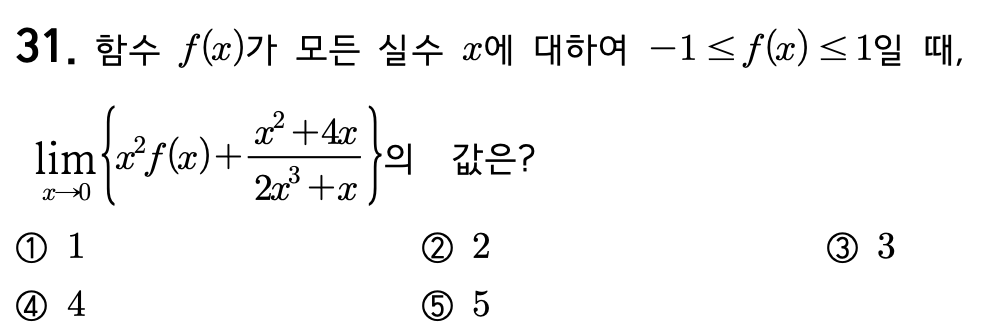



학생 수기 풀이: 


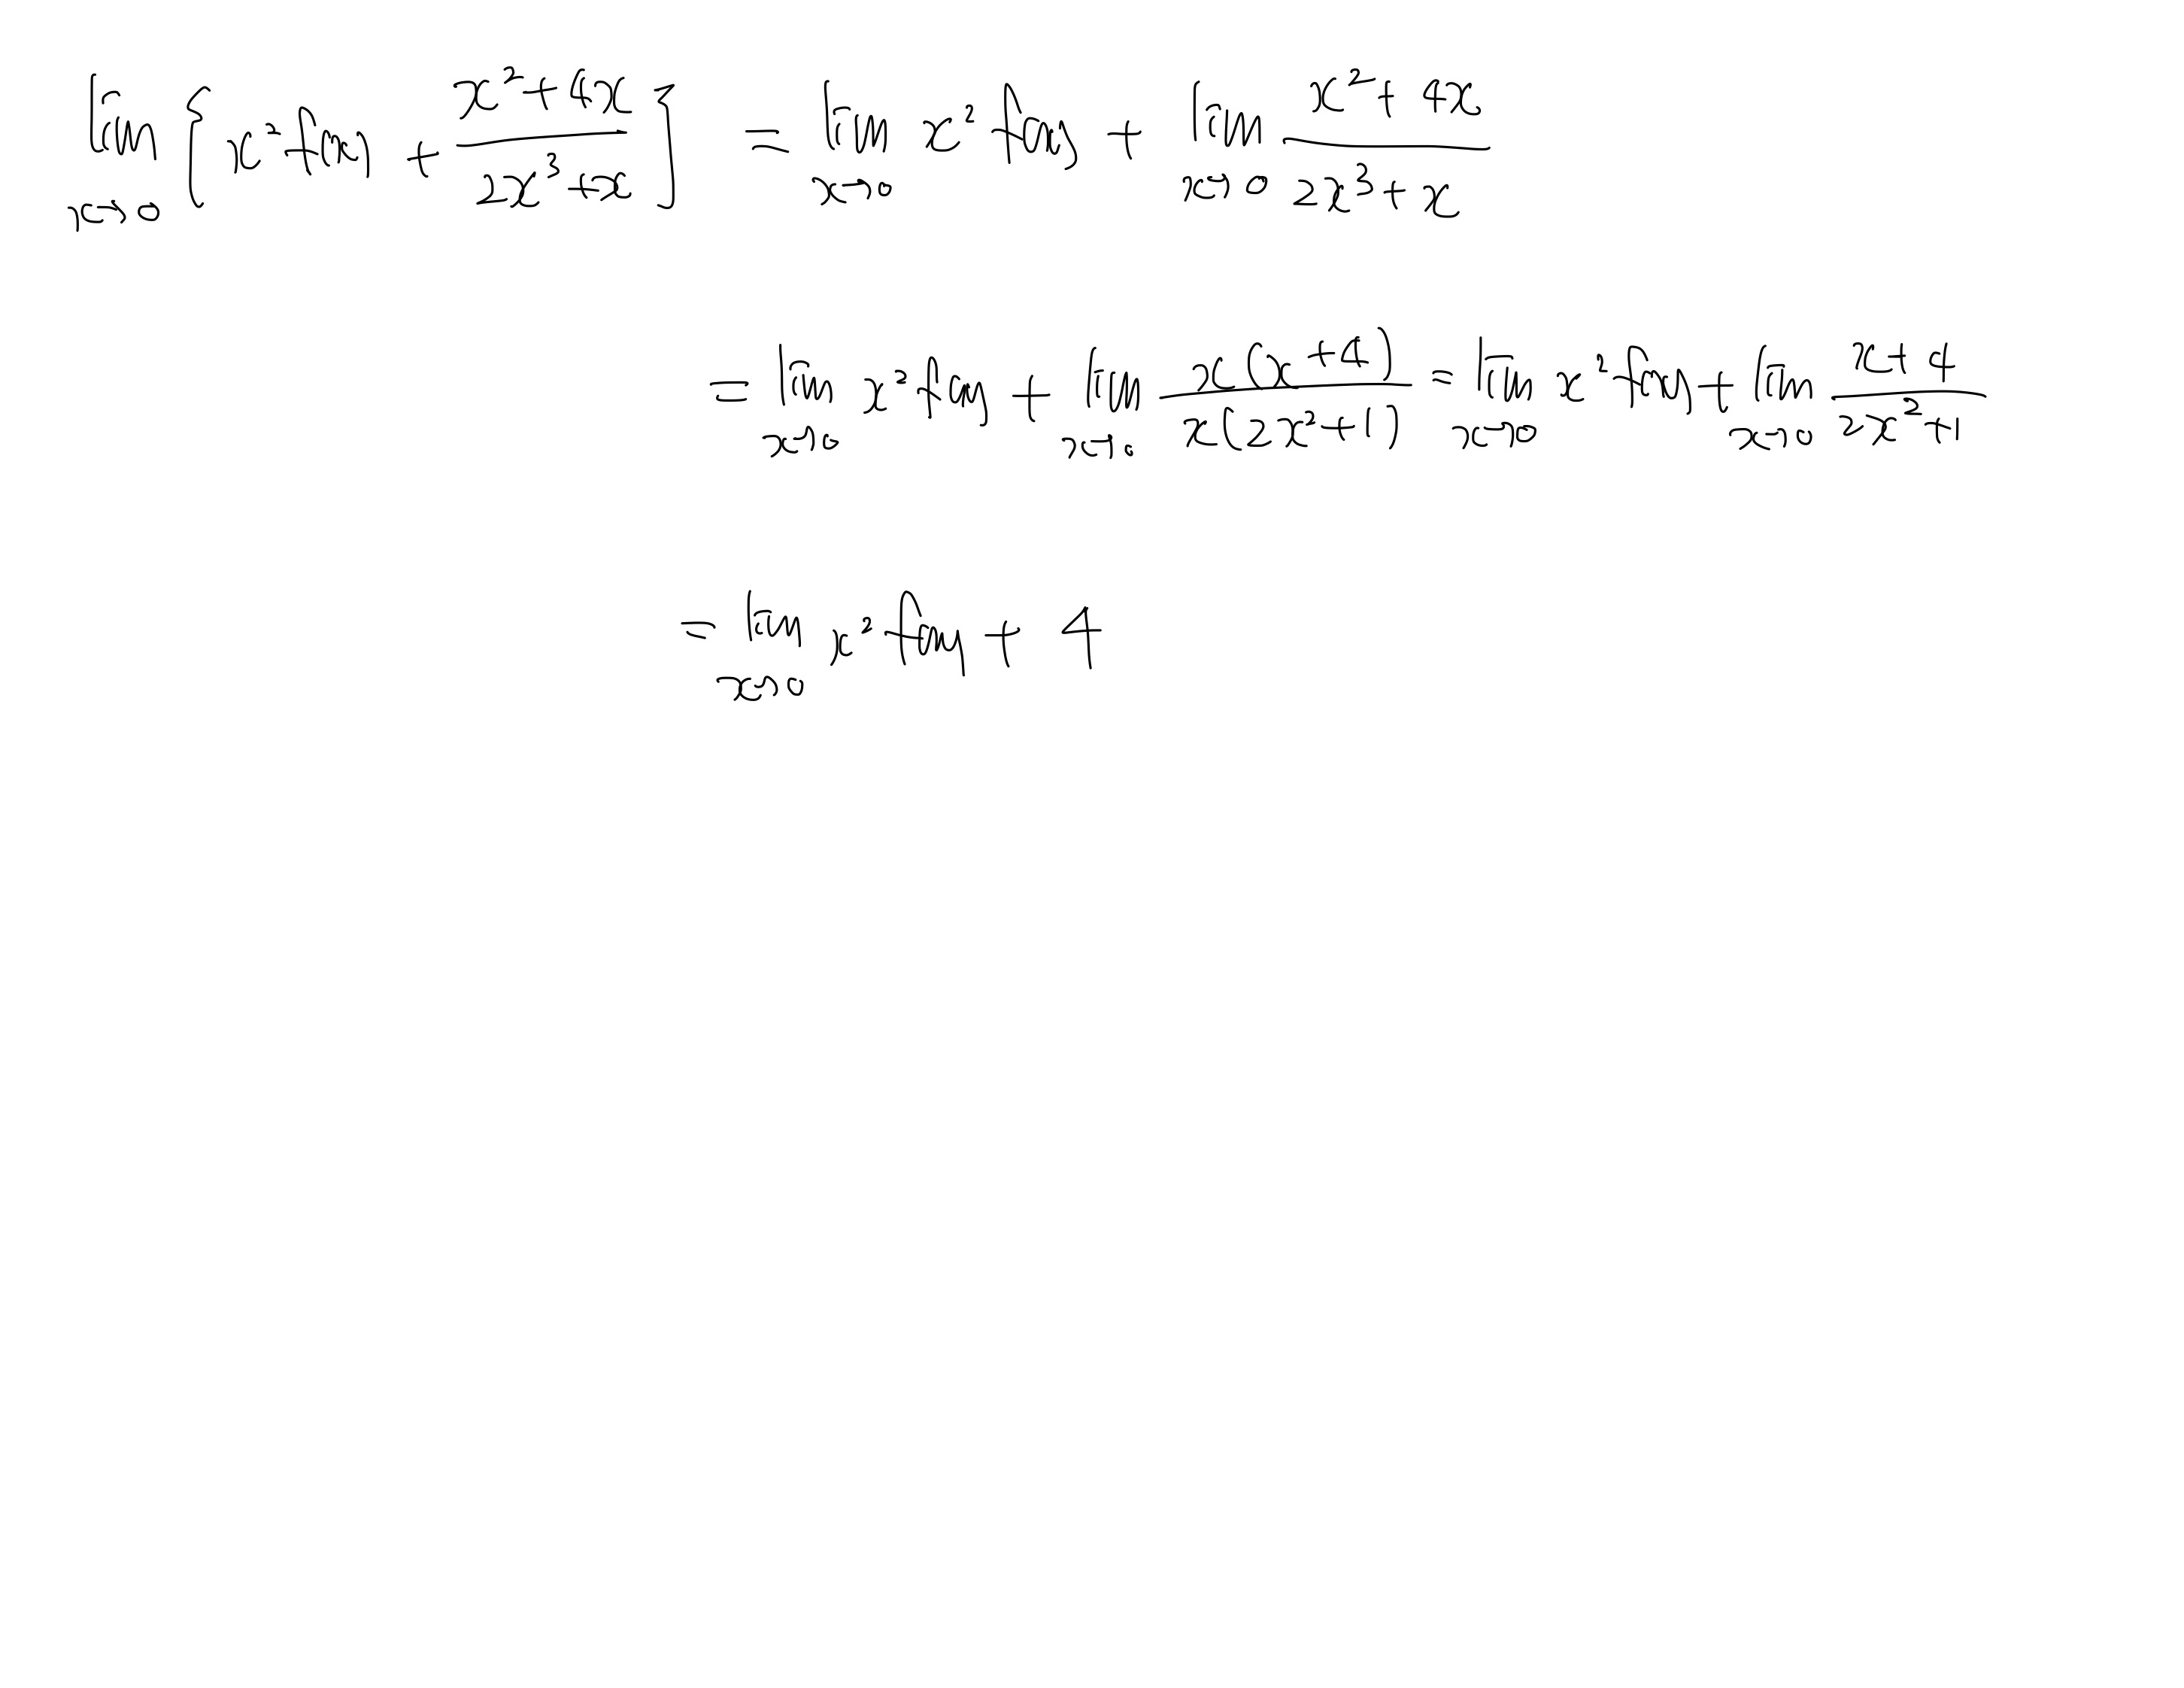

학생 풀이 (OCR 결과):
 \begin{aligned} \lim _{x \rightarrow 0}\left\{x^{2} f(x)+\frac{x^{2}+4 x}{2 x^{3}+x}\right\} & =\lim _{x \rightarrow 0} x^{2} f(x)+\lim _{x \rightarrow 0} \frac{x^{2}+4 x}{2 x^{3}+x} \\ & =\lim _{x \rightarrow 0} x^{2} f \ln y+\lim _{x \rightarrow 0} \frac{x(x+4)}{x\left(2 x^{2}+1\right)}=\lim _{x \rightarrow 0} x^{2} f(x)+\lim _{x \rightarrow 0} \frac{x+4}{2 x^{2}+1} \\ & =\lim _{x \rightarrow 0} x^{2} f \text { fon }+4\end{aligned} 

문제 31의 해설: 
31. 정답 (4)
\[
\begin{array}{l}
-1 \leq f(x) \leq 1 \text { 이므로 }-x^{2} \leq x^{2} f(x) \leq x^{2} \\
\text { 따라서 }-x^{2}+\frac{x^{2}+4 x}{2 x^{3}+x} \leq x^{2} f(x)+\frac{x^{2}+4 x}{2 x^{3}+x} \leq x^{2}+\frac{x^{2}+4 x}{2 x^{3}+x} \text { 에서 } \\
\lim _{x \rightarrow 0}\left(-x^{2}+\frac{x^{2}+4 x}{2 x^{3}+x}\right)=\lim _{x \rightarrow 0}\left(-x^{2}+\frac{x+4}{2 x^{2}+1}\right)=4, \\
\lim _{x \rightarrow 0}\left(x^{2}+\frac{x^{2}+4 x}{2 x^{3}+x}\right)=\lim _{x \rightarrow 0}\left(x^{2}+\frac{x+4}{2 x^{2}+1}\right)=4 \text

In [ ]:
# 사용자 입력 및 힌트 제공
def main():
    #pdf_path = "/content/drive/MyDrive/project/푸리푸리/prob/수2-EBS고난도-01.함수의 극한.pdf"

    # PDF 내용 및 이미지 추출
    #content, images = extract_pdf_content(pdf_path)

    # 메모리에서 이미지 바로 표시
    #display_images_in_memory(images)

    # 사용자에게 문제 번호 입력 받기
    question_number = input("힌트를 알고 싶은 문제 번호를 입력하세요: ")

    prob_image_path = "/content/drive/MyDrive/project/푸리푸리/prob/problem/prob_31.png"

    ocr_image_path = "/content/drive/MyDrive/project/푸리푸리/sol/puripuri test_ocr_31-5.jpg"

    # 문제 이미지 출력
    print(f"문제 {question_number} 이미지: ")
    problem_image = Image.open(prob_image_path)
    display(problem_image)

    # 학생 풀이 ocr
    ocr_image = Image.open(ocr_image_path)
    print(f"\n\n학생 수기 풀이: ")
    display(ocr_image)

    ocr_sol = re.sub(r'\\begin\{array\}\{[lcr]\}|\\end\{array\}', '', extract_math_from_image(ocr_image_path)).strip()
    ocr_sol = re.sub(r'^\s*\\?\(|\\?\)\s*$', '', ocr_sol)
    print(f"학생 풀이 (OCR 결과):\n{ocr_sol}\n")

    # 해당 문제의 해설 부분 추출
    solution_content = find_solution_for_question(content, question_number)

    #for hard coding
    #-------------------------------
    sol_image_path = "/content/drive/MyDrive/project/푸리푸리/sol/31스크린샷 2024-10-16 오후 8.25.05.png"
    solution_content = extract_math_from_image(sol_image_path)
    #-------------------------------


    if "해설을 찾을 수 없습니다" in solution_content:
        print(solution_content)
    else:
        print(f"문제 {question_number}의 해설: \n{solution_content}\n")
        # OpenAI API를 통해 자연어 힌트 생성
        prompt = f"당신은 학생들에게 수학을 가르쳐주는 창의적이고 열정적이며 친절한 수학 선생님입니다.\
                  주어진 이미지는 학생이 풀고 있는 문제입니다.\
                  다음은 해당 문제 해설입니다:\n{solution_content}\n\n\
                  아래 수식은 학생이 해당 문제를 풀다가 막힌 풀이입니다\n{ocr_sol}\n.\
                  학생의 풀이와 문제 해설을 참고하여 학생이 작성한 풀이 직후에 시도해보면 좋은 문제풀이에 대한 힌트를 딱 한가지를 구체적으로 알려주세요.\
                  힌트는 필요하면 계산식은 알려주되 계산 결과값에 대한 언급은 없어야합니다.\
                  학생이 이미 풀이에서 시도한 내용은 무조건 힌트로 언급하지 말아주세요.\
                  "
        hint = generate_hint_from_openai(api_key, prompt, prob_image_path, ocr_image_path)
        print(f"문제 {question_number}의 힌트:\n{hint}")

if __name__ == "__main__":
    main()